# Wordcloud using Hadoop's word count output

This notebook uses R and Hadoop's installation in an Oracle Linux 7.9 VM to create a wordcloud from the MapReduce output of the WordCount example routine.

The output is the word count from 4 files:

* A text file with a series of movie names
* A JSON file that has the same content, but in JSON format
* A Sqoop export of the movie names table from the MySQL database
* A Flume set of tweets from the Twitter API

In [2]:
.libPaths()


[1] "/u02/anaconda3/lib/R/library"

Some variables are required to be set in the environment before running the next lines, which make Hadoop and Java available to R.

Find more on this procedure [here](https://www.notion.so/schreibpunkt/Big-Data-course-final-project-8f5da5129b7744ceb4189c35dc82f589?pvs=4#2ec9279eba9f433d90ba97d902256ceb).

In [3]:
# Set this variable to the location of your Hadoop installation
Sys.setenv(HADOOP_CMD = "/usr/local/hadoop/bin/")
# Same for Java
Sys.setenv(JAVA_HOME = "/usr/local/java")


In [4]:
# Load packages
library("wordcloud")
library("tm")
library("SnowballC")
library("rhdfs")


Loading required package: RColorBrewer

Loading required package: NLP

Loading required package: rJava


HADOOP_CMD=/usr/local/hadoop/bin/


Be sure to run hdfs.init()



In [ ]:
# Ensure Hadoop file system is running
hdfs.init()


In [5]:
# Read the data from Hadoop
data <- system("hdfs dfs -cat /wordcountout/part-r-00000", intern = TRUE)
# data <- hdfs.cat('/wordcountout/part-r-00000')


In [6]:
head(data)


[1] "!\t2"                "\"#MejorPelícula\t1" "\",\"Brothers\t1"   
[4] "\",\"Chungking\t1"   "\",\"Heidi\t12"      "\",\"Maybe,\t1"

In [8]:
# Load data into a vector corpus
corpus <- VCorpus(VectorSource(data))


A "Vector Corpus" refers to a collection of text documents where each document is represented as a vector. In the context of the "tm" package in R, the term "Vector Corpus" is used to describe the structure that holds a set of text documents as vectors.

In text mining and natural language processing, documents are often represented in vector form to enable computational analysis. The vector representation allows mathematical operations and statistical techniques to be applied to the textual data. Each document is typically transformed into a numerical representation, where each dimension of the vector corresponds to a specific term or feature.

Source: ChatGPT (18/5/2023)

Up next, we are removing stopwords (commonly occurring words with little semantic value)

In [9]:
# The tm (text mining) package will be used to clean the data
corpus <- tm_map(corpus, removeWords, stopwords())


Now, we'll remove punctuation and numbers (by removing any non-alphabetic and non-whitespace characters from the string)

In [10]:
RemoveNumPunct <- function(x) gsub("[^[:alpha:][:space:]]*", "", x)


* `gsub` is an R function for pattern matching and replacement.
* `[^[:alpha:][:space:]]*`: This is the regular expression pattern passed to gsub for matching. Let's break it down further:
    * `^`: This symbol within square brackets negates the character class that follows, matching any character that is not within the character class.
    * `[:alpha:]`: This character class represents any alphabetic character.
    * `[:space:]`: This character class represents any whitespace character.
    * `*`: This asterisk denotes that the pattern can occur zero or more times.

In [11]:
# Apply the function to the corpus
mycorpus <- tm_map(corpus, content_transformer(RemoveNumPunct))


In [12]:
# More cleaning, now removing URLs
RemoveURL <- function(x) gsub("http[^[:space:]]*", "", x)
mycorpus <- tm_map(mycorpus, content_transformer(RemoveURL))


In [13]:
# Finally, remove punctuation, make everything lowercase, strip whitespace, and stem the words (e.g. "running" becomes "run")
mycorpus <- tm_map(mycorpus, removePunctuation)
mycorpus <- tm_map(mycorpus, content_transformer(tolower))
mycorpus <- tm_map(mycorpus, stripWhitespace)
mycorpus <- tm_map(mycorpus, stemDocument)


In [14]:
# Remove programmer-defined words, if needed
CustomStopWords <- c("star", "wars")
mycorpus <- tm_map(mycorpus, removeWords, CustomStopWords)


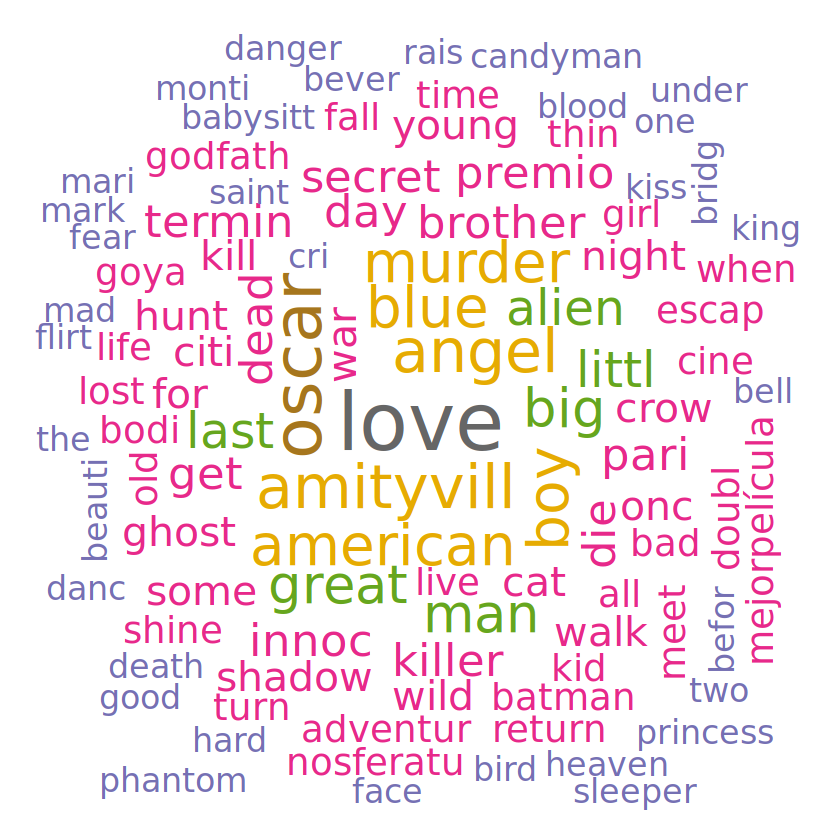

In [15]:
# Plot the wordcloud
wordcloud(
    mycorpus,
    min.freq = 1,
    max.words = 100,
    random.order = FALSE,
    colors = brewer.pal(8, "Dark2")
)
